### **Text Mining Group Project 23-24**

##### **Group 3**

**Elements**:
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Diogo Almeida | ... | ...@novaims.unl.pt
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt


**In this notebook:**
1. Data Extraction from raw file.

**Index**
1. [Library imports](#library_imports)
2. ...

#### **Library Imports**<a id='library_imports'></a>

In [95]:
import os
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bs4 import BeautifulSoup

import fasttext

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from transformers import pipeline

#### **Constants**

In [3]:
SEED = 42

CORPORA_PATH = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(CORPORA_PATH, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(CORPORA_PATH, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(CORPORA_PATH, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(CORPORA_PATH, 'test_reviews.xlsx')

#### **Data Imports**

In [4]:
class Metadata:
    
    """
    Easy access to metadata for the Airbnb dataset.
    """
    
    descriptions = {
        'index': 'index column to identify each property',
        'description': 'property description',
        'host_about': 'host information',
        'unlisted': 'target column: whether the property is unlisted (1) or not (0)',
        'comments': 'guest comments on the property. A property can have multiple or no comments',
    }
    
    @classmethod
    def describe(cls, column):
        return cls.descriptions[column]


# example
print(Metadata.describe('index'))

index column to identify each property


In [5]:
train_info = pd.read_excel(TRAIN_INFO_PATH)
train_reviews = pd.read_excel(TRAIN_REVIEWS_PATH)

print(f'Train info shape: {train_info.shape}')
display(train_info.head())
print()
print(f'Train reviews shape: {train_reviews.shape}')
display(train_reviews.head())

# time to load: ~25s

Train info shape: (6248, 4)


,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0



Train reviews shape: (361281, 2)


,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [6]:
# we might also want to check the test data to ensure compatibility
test_info = pd.read_excel(TEST_INFO_PATH)
test_reviews = pd.read_excel(TEST_REVIEWS_PATH)

assert test_info.columns.tolist() == train_info.columns.tolist()[:-1], 'Test and train info columns do not match'
assert test_reviews.columns.tolist() == train_reviews.columns.tolist(), 'Test and train reviews columns do not match'

#### **Data Exploration**

- **High-level Statistics**

In [7]:
# missing values

# there seems to be blank spaces not being identified as nulls
# r'^\s*$' matches strings that are empty or contain only whitespace
# ^ asserts the start of the string
# \s* matches zero or more whitespace characters (spaces, tabs, newlines, etc.)
# $ asserts the end of the string
train_info = train_info.replace(r'^\s*$', np.nan, regex=True)
train_reviews = train_reviews.replace(r'^\s*$', np.nan, regex=True)

print('Train info missing values:')
print(train_info.isna().sum())

print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())

# to the same to the test set
test_info = test_info.replace(r'^\s*$', np.nan, regex=True)
test_reviews = test_reviews.replace(r'^\s*$', np.nan, regex=True)

print('\nTest info missing values:')
print(test_info.isna().sum())

print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

Train info missing values:
index           0
description     0
host_about     24
unlisted        0
dtype: int64

Train reviews missing values:
index       0
comments    2
dtype: int64

Test info missing values:
index          0
description    0
host_about     2
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64


In [21]:
# is index unique in train_info?
assert train_info['index'].nunique() == train_info.shape[0], 'Index is not unique'
print(f'Total no. of properties in train dataset: {train_info.shape[0]}')

Total no. of properties in train dataset: 6248


Unlisted: 1708 (27.34%)
Listed: 4540 (72.66%)


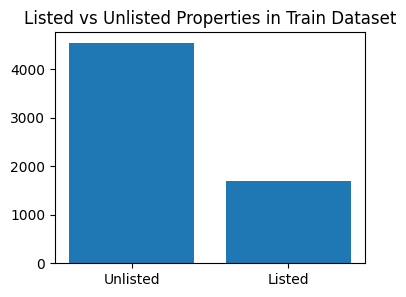

In [10]:
# listed vs unlisted
unlisted = train_info['unlisted'].value_counts()
print(f'Unlisted: {unlisted[1]} ({unlisted[1] / train_info.shape[0] * 100:.2f}%)')
print(f'Listed: {unlisted[0]} ({unlisted[0] / train_info.shape[0] * 100:.2f}%)')

plt.figure(figsize=(4,3))
plt.bar(['Unlisted', 'Listed'], unlisted)
plt.title('Listed vs Unlisted Properties in Train Dataset')
plt.show()

# ... some data imbalance, might need to address this later

In [26]:
# property reviews
reviews_per_property = train_reviews['index'].value_counts()

total_properties = train_info.shape[0]
properties_with_reviews = reviews_per_property.shape[0]
properties_without_reviews = total_properties - properties_with_reviews

print(f'Properties with reviews: {properties_with_reviews} ({properties_with_reviews / total_properties * 100:.2f}%)')
print(f'Properties without reviews: {properties_without_reviews} ({properties_without_reviews / total_properties * 100:.2f}%)')

Properties with reviews: 4245 (67.94%)
Properties without reviews: 2003 (32.06%)


In [33]:
# stats on reviews per property
avg_reviews_per_property = reviews_per_property.mean()
print(f'Average reviews per property: {avg_reviews_per_property:.2f}')
print(f'Median reviews per property: {reviews_per_property.median():.0f}')
print(f'Mode of reviews per property: {reviews_per_property.mode()[0]}')
print(f'Standard deviation of reviews per property: {reviews_per_property.std():.2f}')

Average reviews per property: 85.11
Median reviews per property: 48
Mode reviews per property: 1
Standard deviation of reviews per property: 96.49


- **Data Cleaning ahead of text field analysis**

In [ ]:
# language detection
# wordcounts by field (some cleaning beforehand is needed)
# sentiment analysis on comments (chi-square test to check if sentiment is correlated to target)

In [8]:
# cleaning functions
# NOTE some of this functions will be used for data pre processing!

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text


def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns (often used to indicate line breaks)
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text


def remove_functional_punctuation(text):
    # Remove punctuation that is not indicative of sentiment
    # Keep ! and ? as they can indicate sentiment
    text = re.sub(r'[.,;:()\[\]{}]', '', text)
    return text


def remove_or_replace_mentions(text):
    # '@' seems to be either used as a simplification of the word 'at'
    # or a mention. Therefore, if '@' is not attached to any other characters
    # then we will replace it with 'at', else will remove it as well as the
    # characters glued to it.
    if '@' in text:
        text = re.sub(r' @ ', 'at', text)
        text = re.sub(r'@(\w+)', '', text)
    return text


def remove_urls(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    return text


def remove_or_replace_hashtags(text):
    # not sure if they are really used as hashtags
    # but rather to mean 'number'/'best', e.g. # 1 spot in town!
    if '#1' or '# 1':
        text = re.sub(r'#\s?\b1\b', 'best', text)
    text = re.sub(r'#(\w+)', '', text)
    return text


# not used
def remove_or_replace_and(text):
    if '&' in text:
        text = re.sub(r'&', 'and', text)


def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text


def remove_double_withspaces(text):
    # the previous transformations might end up
    # creating duplicate whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text


def lower_case(text):
    return text.lower()


def strip(text):
    return text.strip()

In [9]:
# function chainer
# select which cleaning functions to use

def clean_text(text):
    # skip nans
    if pd.isna(text):
        return text
        
    text = remove_html_tags(text)
    text = remove_emojis_and_special_characters(text)
    text = remove_control_characters(text)
    text = remove_functional_punctuation(text)
    text = remove_or_replace_mentions(text)
    text = remove_urls(text)
    text = remove_or_replace_hashtags(text)
    text = remove_numbers(text)
    text = remove_double_withspaces(text)
    text = lower_case(text)
    text = strip(text)
    
    return text

In [10]:
# cleaning

train_info['clean_description'] = train_info['description'].apply(clean_text)
train_info['clean_host_about'] = train_info['host_about'].apply(clean_text)
train_reviews['clean_comments'] = train_reviews['comments'].apply(clean_text)

# takes around ~90s

- **Language Detection**

In [11]:
# using the fasttext library to help detect language of text fields
# it is much faster than other popular libraries like langdetect

# how to:
# 1. go to: https://fasttext.cc/docs/en/language-identification.html
# 2. download lid.176.ftz and place it in the language-detection folder (if you have no such folder, create it beforehand)
# example: https://huggingface.co/facebook/fasttext-language-identification

class LanguageDetector:
    def __init__(self):
        self.model = self.load_model()
    
    def load_model(self):
        model = fasttext.load_model(os.path.join('language-detection', 'lid.176.ftz'))
        return model
    
    def detect_language(self, text):
        if pd.isna(text):
            return text
        return self.model.predict(text)[0][0].split('__')[-1]
    

language_detector = LanguageDetector()
train_info['clean_description_lang'] = train_info['clean_description'].apply(lambda text: language_detector.detect_language(text))
train_info['clean_host_about_lang'] = train_info['clean_host_about'].apply(lambda text: language_detector.detect_language(text))
train_reviews['clean_comments_lang'] = train_reviews['clean_comments'].apply(lambda text: language_detector.detect_language(text))

description_languages = train_info['clean_description_lang'].value_counts()
host_about_languages = train_info['clean_host_about_lang'].value_counts()
comments_languages = train_reviews['clean_comments_lang'].value_counts()

print(f"No. of unique languages in clean_description_lang: {len(description_languages)}")
print(f"No. of unique languages in clean_host_about_lang: {len(host_about_languages)}")
print(f"No. of unique languages in clean_comments_lang: {len(comments_languages)}")

No. of unique languages in clean_description_lang: 10
No. of unique languages in clean_host_about_lang: 15
No. of unique languages in clean_comments_lang: 67


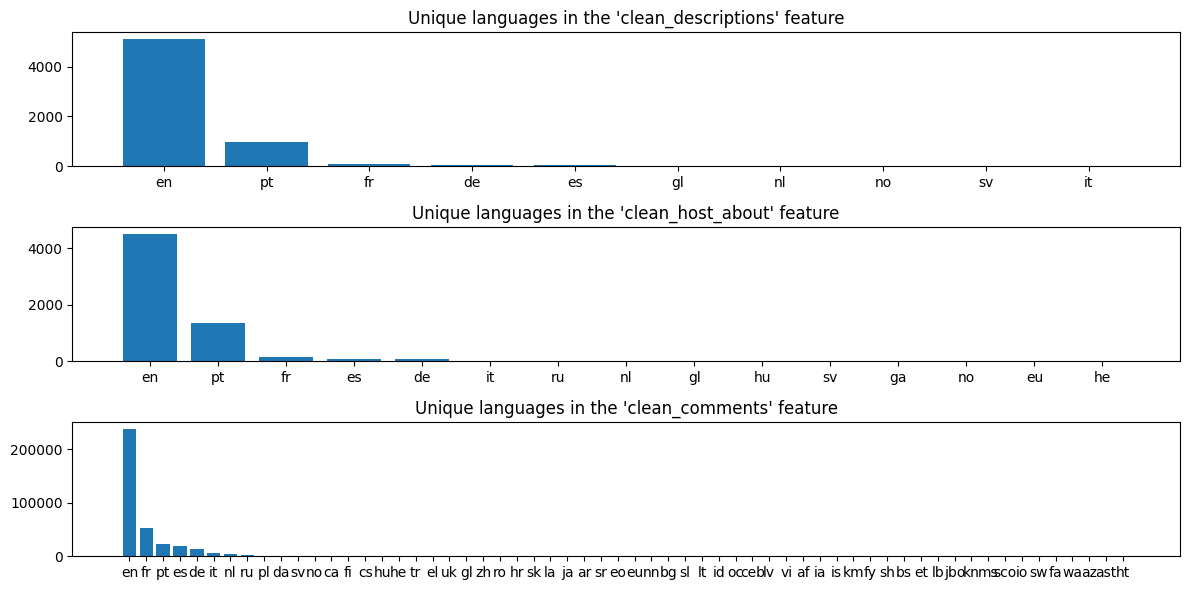

In [30]:
# plot most common languages

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

ax1.bar(description_languages.index, description_languages)
ax1.set_title("Unique languages in the 'clean_descriptions' feature")

ax2.bar(host_about_languages.index, host_about_languages)
ax2.set_title("Unique languages in the 'clean_host_about' feature")

ax3.bar(comments_languages.index, comments_languages)
ax3.set_title("Unique languages in the 'clean_comments' feature")

plt.tight_layout()
plt.show()

In [52]:
# the majority of text data is written in english or one of the romance languages

romance_languages = [
    'pt', 
    'fr',
    'es',
    'it',
    'ro'  # fyi, romanian
]

print('Proportion of observations in english or romance languages:')
print(f"\tdescriptions: {sum([v for k,v in description_languages.items() if k in ['en'] + romance_languages]) / sum(description_languages):.2f}")
print(f"\thost_about: {sum([v for k,v in host_about_languages.items() if k in ['en'] + romance_languages]) / sum(host_about_languages):.2f}")
print(f"\tcomments: {sum([v for k,v in comments_languages.items() if k in ['en'] + romance_languages]) / sum(comments_languages):.2f}")

Proportion of observations in english or romance languages:
	description: 0.99
	host_about: 0.98
	comments: 0.94


In [33]:
# all unique languages

uq_languages = set(
    list(description_languages.index) +
    list(host_about_languages.index) +
    list(comments_languages.index)
)

print(f"Total unique languages: {len(uq_languages)}")

Total unique languages: 61


In [ ]:
# ... and on the test set?

- **Word Count**

In [26]:
def word_counter(text):
    if pd.isna(text):
        return 0
    return len(text.split(' '))

word_count_description = train_info['clean_description'].map(word_counter)
word_count_host_about = train_info['clean_host_about'].map(word_counter)
word_count_comments = train_reviews['clean_comments'].map(word_counter)

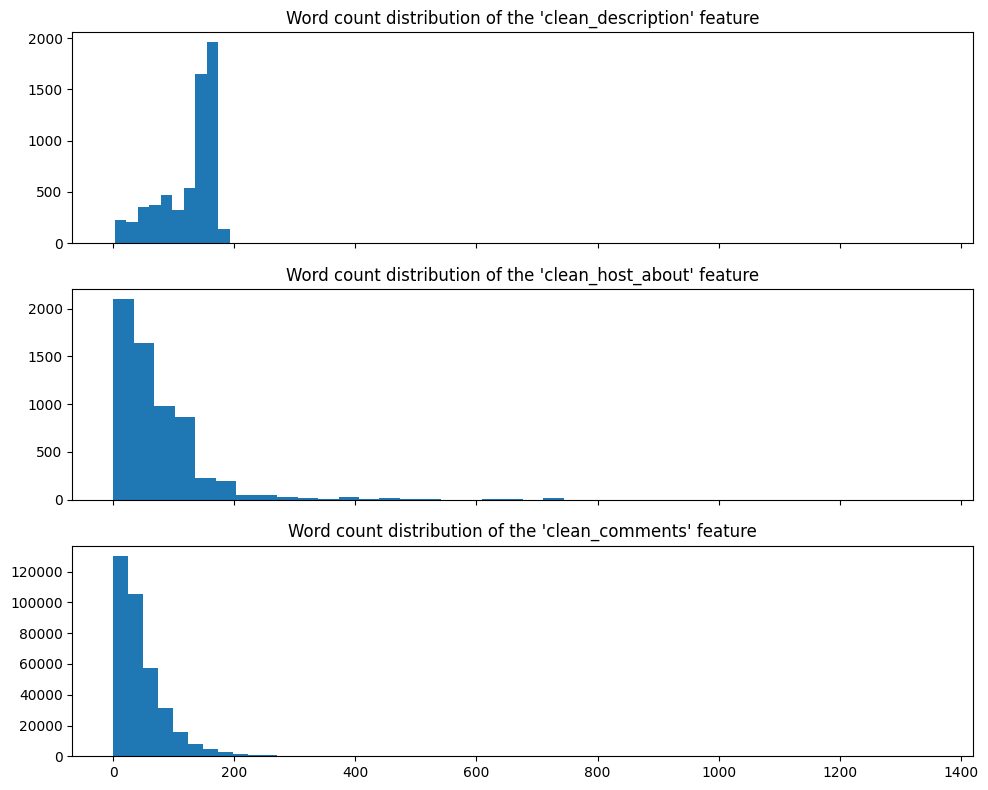

In [36]:
# plot most common languages

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax1.hist(word_count_description, bins=10)
ax1.set_title("Word count distribution of the 'clean_description' feature")

ax2.hist(word_count_host_about, bins=40)
ax2.set_title("Word count distribution of the 'clean_host_about' feature")

ax3.hist(word_count_comments, bins=40)
ax3.set_title("Word count distribution of the 'clean_comments' feature")

plt.tight_layout()
plt.show()

- **Text Translation to English**

In [68]:
# what to do to languages that are not possible to translate?

pretrained_translators_names = {
    'af': None,  # afrikaans
    'ar': None,  # arabic
    'ast': None, # asturian (no asturian, using romance)
    'az': None, # azerbaijani
    'bg': None, # bulgarian
    'bs': None, # bosnian
    'ca': None, # catalan
    'ceb': None, # cebuano
    'cs': None, # czech
    'da': 'Helsinki-NLP/opus-mt-da-en', # danish
    'de': 'Helsinki-NLP/opus-mt-en-de', # german
    'el': None, # greek
    'en': None, # english (no translation needed)
    'eo': None, # esperanto
    'es': 'Helsinki-NLP/opus-mt-ROMANCE-en', # spanish
    'et': None, # estonian
    'eu': None, # basque
    'fa': None, # persian
    'fi': None, # finnish
    'fr': 'Helsinki-NLP/opus-mt-ROMANCE-en', # french
    'fy': None, # frisian
    'ga': None, # irish
    'gl': None, # galecian
    'he': None, # hebrew
    'hr': None, # croatian
    'ht': None, # haitian creole
    'hu': None, # hungarian
    'ia': None, # interlingua
    'id': None, # indonesian
    'io': None, # ido
    'is': None, # icelandic
    'it': 'Helsinki-NLP/opus-mt-ROMANCE-en', # italian
    'ja': None, # japanese
    'jbo': None, # lojban
    'km': None, # khmer
    'kn': None, # kannada
    'la': None, # latin
    'lb': None, # luxembourghish
    'lt': None, # lithuanian
    'lv': None, # latvian
    'ms': None, # malay
    'nl': 'Helsinki-NLP/opus-mt-nl-en', # dutch
    'nn': None, # norwegian (nynorsk)
    'no': None, # norwegian
    'oc': None, # occitan
    'pl': 'Helsinki-NLP/opus-mt-pl-en', # polish
    'pt': 'Helsinki-NLP/opus-mt-ROMANCE-en', # portuguese
    'ro': 'Helsinki-NLP/opus-mt-ROMANCE-en', # romanian
    'ru': 'Helsinki-NLP/opus-mt-ru-en', # russsian
    'sco': None, # scots
    'sh': None, # serbo-croatian
    'sk': None, # slovak
    'sl': None, # slovenian
    'sr': None, # serbian
    'sv': None, # swedish
    'sw': None, # swahili
    'tr': None, # turkish
    'uk': None, # ukranian
    'vi': None, # vietnamese
    'wa': None, # walloon
    'zh': None # chinese
}

able_to_translate = [k for k,v in pretrained_translators_names.items() if v is not None]
print('Proportion of observations in english or languages that we can translate into english:')
print(f"\tdescriptions: {sum([v for k,v in description_languages.items() if k in ['en'] + able_to_translate]) / sum(description_languages):.4f}")
print(f"\thost_about: {sum([v for k,v in host_about_languages.items() if k in ['en'] + able_to_translate]) / sum(host_about_languages):.4f}")
print(f"\tcomments: {sum([v for k,v in comments_languages.items() if k in ['en'] + able_to_translate]) / sum(comments_languages):.4f}")

# ... it seems that we are able to translate >99% of all the texts
# what if, if we use translation, we can just hard predict 'listed'
# (the majority class) for all instances where we can't translate?

Proportion of observations in english or languages that we can translate into english:
	descriptions: 0.9992
	host_about: 0.9979
	comments: 0.9955


In [111]:
# possibility: https://huggingface.co/docs/transformers/model_doc/marian
# multilingual translator: https://huggingface.co/datasets/Helsinki-NLP/opus-100

# TODO checkout this lib: https://github.com/UKPLab/EasyNMT

# can we use a sample to perform sentiment analysis?
# but what about other the other languages when we want to do predictions?

class MultiLingualTranslator:
    def __init__(self, pretrained_translators_names):
        self.pretrained_translators_names = pretrained_translators_names
        self.loaded_pipelines = {}

    def load_pipeline(self, model_name):
        if model_name not in self.loaded_pipelines:
            pipe = pipeline("translation", model=model_name)
            self.loaded_pipelines[model_name] = pipe
        else:
            pipe = self.loaded_pipelines[model_name]
            
        return pipe

    def _get_model_name(self, lang):
        return self.pretrained_translators_names.get(lang)

    def translate_to_english(self, text, lang) -> str:
        if lang == 'en':
            return text
        elif lang not in [k for k,v in pretrained_translators.items() if v is not None]:
            return np.nan

        model_name = self._get_model_name(lang)
        pipe = self.load_pipeline(model_name)
        # output of pipe is a list of dicts, e.g. [{'translation_text': '...'}]
        translation = pipe(text)[0]["translation_text"]
        return translation

# it seems that translation affects some cleaning tasks
# e.g. adds puncation
# capitalizes some letters
# ... need to re-clean

In [ ]:
translator = MultiLingualTranslator(pretrained_translators_names)

def translate(text, lang, clean=True):
    # text might be null
    if pd.isna(text):
        return text

    translation = translator.translate_to_english(text, lang)

    # the class returns np.nan for languages without translator model
    if pd.isna(translation):
        return translation

    if clean:
        # translation seems able to add punctuation
        # and capitalize some letters
        translation = remove_functional_punctuation(translation)
        translation = lower_case(translation)
    
    return translation

# doing it this way just because of the tqdm
def apply_clean_translation_to_df(text_column, lang_column):
    new_col = []
    for text, lang in tqdm(zip(text_column, lang_column), total=len(text_column), desc="Translating text"):
        translation = translate(text, lang)
        new_col.append(translation)


# ... takes an unfeasible amount of time
# train_info['translated_clean_description'] = apply_clean_translation_to_df(train_info['clean_description'], train_info['clean_description_lang'])
# train_info['translated_clean_host_about'] = apply_clean_translation_to_df(train_info['clean_host_abou'], train_info['clean_host_abou_lang'])
# train_info['translated_clean_comments'] = apply_clean_translation_to_df(train_reviews['clean_comments'], train_reviews['clean_comments_lang'])

In [51]:
# TODO maybe use this for translating other languages?
# if yes add it to class

from deep_translator import GoogleTranslator
translated = GoogleTranslator(source='pt', target='en').translate("bom dia chamo me frederico")
translated

# ... also need to re-clean text
# ... also takes a lot of time

- **Sentiment Analysis of the 'comments' feature**

In [ ]:
# there are basically 3 types of sentiment analysis:
# 1. lexicon-based
# 2. machine learning-based
# 3. pre-trained transformer-based deep learning

# ... maybe we only need the simplest method?

# since translation might not be viable we can use the english reviews as a sample
# and do sentiment analysis on those?

# example of lexicon-based sentiment analysis: https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

In [106]:
en_comments = train_reviews.loc[train_reviews['clean_comments_lang'] == 'en', ['index', 'clean_comments']]  # later will merge with the unlisted feature

print('No. of english ocurrences:')
print(f'\t comments: {len(en_comments)}/{len(train_reviews)}')

# ... shouldn't description and host_about have the exact same numbers?

No. of english ocurrences:
	 comments: 238351 / 361281


In [107]:
# some pre processing functions, besides simple text cleaning, may help
# the accuracy of the sentiment analysis

# instantiating outside of function to speed up process
en_stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_en_text(text):

    # tokenizing the text
    tokens = word_tokenize(text)

    # removing stop words
    filtered_tokens = [token for token in tokens if token not in en_stop_words]

    # lemmatizing the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # joining the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text


en_comments['processed_comments'] = en_comments['clean_comments'].apply(preprocess_en_text)

# ... takes around 2 min

In [108]:
# sentiment analyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # compound ranges from -1 to 1
    # compound > .5 instead of 0
    sentiment = 1 if scores['compound'] > .5 else 0
    return sentiment


en_comments['processed_comments_sentiment'] = en_comments['processed_comments'].apply(get_sentiment)
print(en_comments['processed_comments_sentiment'].value_counts())

# ... takes around 2 min

processed_comments_sentiment
1    221268
0     17083
Name: count, dtype: int64


In [109]:
# re-structuring the df

# there can be multiple comments for a house
# se we first should take the mode scores
# and then turn it to boolean like the rest
# (hence we did not want to convert to bool)

def mode(series):
    mode = pd.Series.mode(series)
    if len(mode) > 1:
        mode = 0
    return mode

en_comments = (
    en_comments
    .groupby('index')
    .agg({'processed_comments_sentiment': lambda x: mode(x)})
    .reset_index()
)

# merging with info df to get the unlisted feature
en_comments = en_comments.merge(train_info[['index', 'unlisted']],
                                on='index', how='left')

In [110]:
# chi-square test for independence
# H0: There is no significant relationship between Variable A and Variable B.
# vs.
# H1: There is a significant relationship between Variable A and Variable B
# therefore, rejecting the null suggests that there is evidence of an
# association between the variables.

contingency_table = pd.crosstab(en_comments['processed_comments_sentiment'],
                                en_comments['unlisted'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)
# print("Degrees of freedom:", dof)
# print("Expected frequencies:")
# print(expected)
print(f"\nConclusion: {'Reject' if p < 0.05 else 'Fail to reject'} the null.")

Chi-square statistic: 9.07502660414605
p-value: 0.002591238062242306

Conclusion: Reject the null.


In [ ]:
# limitations
# ... english observations might not be representative of the whole data
# ... data cleaning / processing might cause bias
# ... reviews might put out mixed signals, e.g. bad review about property, positive reiew
#     about trip, 'apartment was awful but the city was mesmerizing', model might predict
#     positive sentiment.
# ... lack of accuracy of the sentiment analyser used
# ... lack of power of the chi-square test

#### **Data Merge (for both train and test datasets)**

In [ ]:
# can we treat each property-guest review as independent?
# ... IMO yes, since we reviews are not dated and therefore
# we cannot establish a temporal relationship between them
# e.g. if last 5 reviews are bad then house is more likely
# to be unlisted.



In [ ]:
# merging, for train and test datasets, info and reviews

#### **Train Data Split**

Although during data exploration we have employed several pre-processing and feature engineering techniques the data split will be of the raw data since the techniques employed might be undone later on / new techniques might be employed.

In [ ]:
# train-val-test split
# due to sheer amount of data k-fold cross-validation will not be feasible


# TODO rewrite this code

# X = images.copy()
# y = [pathlib.Path(path).parts[2] for path in images].copy()

# def two_step_proportions(train_p, val_p, test_p):
#     """
#     Since we need to split the data in two steps
#     this function returns the proportions of the
#     'test_size' arg. needed to get the true prop.
#     """ 
#     return (test_p, 1-(train_p/(1-test_p)))

# test_size_1, test_size_2 = two_step_proportions(.7, .15, .15)

# X_train_val, X_test, y_train_val, y_test = train_test_split(X,
#                                                             y,
#                                                             test_size=test_size_1,
#                                                             shuffle=True,
#                                                             stratify=y,
#                                                             random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train_val,
#                                                   y_train_val,
#                                                   test_size=test_size_2,
#                                                   shuffle=True,
#                                                   stratify=y_train_val,
#                                                   random_state=42)

# get_prop = lambda d: round(len(d) / len(X) * 100, 2)
# print('Dataset shapes:')
# print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
# print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
# print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
# print(f"\nTotal observations: {len(X)}")